<a href="https://colab.research.google.com/github/swoo-nam/project_final_team1/blob/main/%EB%82%A8%EC%83%81%EC%9A%B0_%EC%9C%A0%EC%98%88%EC%8A%AC_%EC%9E%84%EC%8B%9C%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 런타임 다시 시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,604 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120895 files and dire

In [2]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=f0538caef24a6903459aec34646cd79d37310e6d023470e8b91a2c8e0220e677
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
from torch import optim
from torch import optim

import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# DATA_PATH = '/content/drive/MyDrive/멀티캠퍼스 자료/Machine Learning/data/'
DATA_PATH = "/content/drive/MyDrive/project_final/data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# 데이터 불러오기

In [6]:
pd.read_csv(f"{DATA_PATH}temporary_df.csv").head(3)

,ID,date,review,reply,sentiment,score
0,ae**,2023-07-01,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",죄송합니다. 음식이 맛있지 않았던 점에 대해 정말로 죄송합니다. 저희는 항상 최상의...,0,-0.942769
1,ak**,2023-07-02,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","고객님께서는 음식의 맛과 촉감에 대해 불만을 표시해주셨는데, 이는 많이 실망스러워하...",0,-0.942769
2,am**,2023-07-03,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님께 불편을 드려 정말 죄송합니다. 담당자에게 알려서 조치를 취하도록 하겠습니다.,0,-0.942769


In [7]:
train = pd.read_csv(f"{DATA_PATH}temporary_df.csv")

In [25]:
train_pos = train[train['sentiment'] == 1]
train_neg = train[train['sentiment'] == 0]

train_pos.shape, train_neg.shape

((500, 6), (500, 6))

# 1) 유사도 확인

## 유사도 군집화 라벨 불러오기

In [14]:
pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

,label
0,맛이 없어요
1,양이 적어요
2,배달이 느려요
3,맛은 있는데 양이 적어요
4,맛은 있는데 배달이 느려요
5,양은 많은데 맛이 없어요
6,배달은 빠른데 맛이 없어요
7,양은 많은데 배달이 느려요
8,배달은 빠른데 양이 적어요
9,맛있어요


In [27]:
sim_cluster_label = pd.read_csv(f"{DATA_PATH}sim_cluster_label_2.csv")

### BLEU 계산 함수

In [10]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(text, generated_text):
    y = [text]  # 실제 데이터 y
    X = generated_text  # 생성된 텍스트 X

    # BLEU 점수 계산
    bleu_score = sentence_bleu(y, X)
    return bleu_score

### PPL

In [31]:
import nltk
from nltk import ngrams
import math

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

def calculate_ppl(text):
    tokens = nltk.word_tokenize(text)
    ngrams_list = list(ngrams(tokens, 1))
    ngram_model = nltk.FreqDist(ngrams_list)

    # PPL 계산
    total_log_prob = 0
    for ngram in ngrams_list:
        prob = ngram_model.freq(ngram)
        total_log_prob += -math.log(prob, 2)

    # PPL 값 계산
    ppl = 2 ** (total_log_prob / len(ngrams_list))
    return ppl

def evaluate_text_similarity(label_text, review_text):
    label_ppl = calculate_ppl(label_text)
    review_ppl = calculate_ppl(review_text)

    similarity_score = 1 / (1 + abs(label_ppl - review_ppl))
    return similarity_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [32]:
# 예제 사용법
label_text = "맛도 있고 배달도 빨라요."
review_text = "맛있어요 배달이 빨라요"

similarity_score = evaluate_text_similarity(label_text, review_text)
print(f"유사성 점수: {similarity_score:.2f}")

유사성 점수: 0.33


### cos+jac 유사도

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def evaluate_similarity(label_text, review_text, alpha=0.9): # cosine 가중치 조절
    label_embedding = bert_model.encode(label_text)
    review_embedding = bert_model.encode(review_text)

    # 코사인 유사도
    cosine_sim = 1 - pairwise_distances([label_embedding], [review_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    label_tokens = set(label_text.split())
    review_tokens = set(review_text.split())
    jaccard_sim = len(label_tokens.intersection(review_tokens)) / len(label_tokens.union(review_tokens))

    # 가중 평균 내보기
    weighted_sim = alpha*cosine_sim + (1 - alpha)*jaccard_sim

    return weighted_sim

In [30]:
result = []
for label in tqdm(sim_cluster_label['label']):
    for review in train_neg['review']:
        score = evaluate_text_similarity(review, label)
        # score = evaluate_similarity(label,review)
        if score >= 0.5:
            result.append({'label': label, 'review': review, 'score': score})

result = pd.DataFrame(result)
result

  0%|          | 0/6 [00:00<?, ?it/s]

,label,review,score
0,맛은 있는데 양이 적어요,가격에 비해 품질이 별로였어요.,0.500000
1,맛은 있는데 양이 적어요,맛이 별로였어요. 서비스도 별로였어요.,0.819513
2,맛은 있는데 양이 적어요,맛이 많이 싱겁고 별로였어요.,0.500000
3,맛은 있는데 양이 적어요,맛이 별로였어요. 가격대비 실망스러워요.,0.567471
4,맛은 있는데 양이 적어요,양이 적고 맛도 별로였어요,1.000000
...,...,...,...
181,배달은 빠른데 양이 적어요,항상 맛있었는데 오늘은 고기가 질기네요,0.500000
182,배달은 빠른데 양이 적어요,맛이 좀 떨어지고 식감이 좀 부족했어요,0.567471
183,배달은 빠른데 양이 적어요,가격부적절하고 양적도 부족하고 별로인집,1.000000
184,배달은 빠른데 양이 적어요,맛이 전체적으로 짜네요 국물도요.,0.500000


In [ ]:
result.to_csv('result_2.csv', index=False, encoding = "utf-8-sig")

# 엑셀로 확인
with pd.ExcelWriter("result_2.xlsx", engine='openpyxl') as writer:
    result.to_excel(writer, sheet_name='시트1', index=False)

In [ ]:
result = pd.read_csv(f"{DATA_PATH}result_2.csv")

In [ ]:
label_counts = result['label'].value_counts()
label_counts

양은 많은데 맛이 없어요     262
맛은 있는데 양이 적어요     166
맛은 있는데 배달이 느려요    129
배달은 빠른데 맛이 없어요    111
양은 많은데 배달이 느려요     51
배달은 빠른데 양이 적어요     26
Name: label, dtype: int64

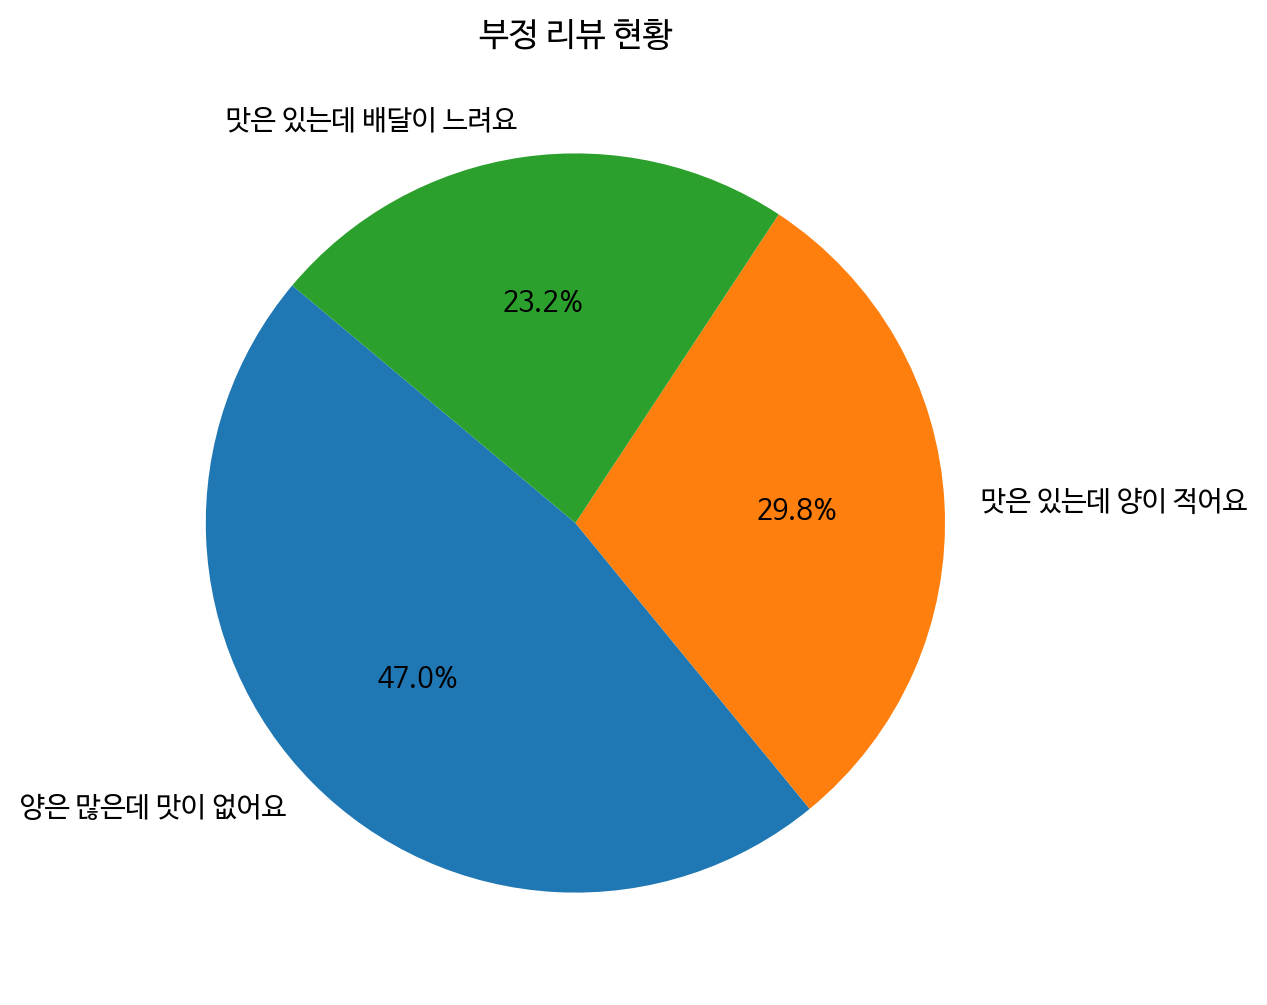

In [ ]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='NanumBarunGothic')

plt.figure(figsize=(6, 6))
plt.pie(label_counts[:3], labels=label_counts[:3].index, autopct='%1.1f%%', startangle=140)
plt.title('부정 리뷰 현황')
plt.show()

# 2) 긍부정 지수 변화 추이

In [ ]:
train_pos = train[train['sentiment'] == 1]
train_neg = train[train['sentiment'] == 0]

train_pos.shape, train_neg.shape

((500, 6), (500, 6))

In [ ]:
# 부정지수 양수로 바꾸기
def change_score(df):
    if df['sentiment'] == 0:
        return -df['score']
    else:
        return df['score']

train_neg['score'] = train_neg.apply(change_score, axis=1)
train_neg

,ID,date,review,reply,sentiment,score
0,ae**,2023-07-01,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",죄송합니다. 음식이 맛있지 않았던 점에 대해 정말로 죄송합니다. 저희는 항상 최상의...,0,0.942769
1,ak**,2023-07-02,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","고객님께서는 음식의 맛과 촉감에 대해 불만을 표시해주셨는데, 이는 많이 실망스러워하...",0,0.942769
2,am**,2023-07-03,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님께 불편을 드려 정말 죄송합니다. 담당자에게 알려서 조치를 취하도록 하겠습니다.,0,0.942769
3,ap**,2023-07-04,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",죄송합니다. 다음에는 더 맛있는 음식을 제공하도록 노력하겠습니다.,0,0.942769
4,ar**,2023-07-05,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","안녕하세요, 죄송합니다. 음식이 촉촉하지 않고 식어서 맛이 좋지 않았던 점에 대해 ...",0,0.942769
...,...,...,...,...,...,...
557,b1**,2023-08-08,"맛이 좀 떨어졌어요, 이전에 먹었을 때는 더 맛있었어요",맛이 좀 떨어졌다니 정말 죄송합니다. 이전에는 더 맛있으셨다니 저희도 아쉬워요. 더...,0,0.845809
558,ae**,2023-08-09,배달이 조금 늦어서 기다린 시간이 길었어요. 좀 아쉬웠어요,고객님의 만족을 위해 더 나은 서비스를 제공할 수 있도록 노력하겠습니다. 감사합니다.,0,0.876207
559,ak**,2023-08-10,가성비 좋은 치킨집이라 시켰는데. 치킨은 무난하게 맛있었는데 치킨에 있는 떡을 먹자...,정말 죄송하다는 말씀을 먼저 드립니다 화요일날 아침에 생산된 떡을 전날 발주넣어 받...,0,0.875962
598,eu**,2023-08-19,오늘 처음 먹었는데 배달이 1시간 걸렸어요 밥이랑 찌개 양은 많이 주시네요. 근데 ...,고객님들이 만족하시는 시간 되실 수 있게 노력하겠습니다,0,0.345111


In [ ]:
# Datetime 형식으로 바꾸기
train_pos['date'] = pd.to_datetime(train_pos['date'])
train_neg['date'] = pd.to_datetime(train_neg['date'])

# 인덱스 설정해서 7D 단위로 확인
train_pos.set_index('date', inplace=True)
train_neg.set_index('date', inplace=True)

train_pos['score'].resample('7D').sum()

date
2023-07-01     3.322375
2023-07-08     3.279000
2023-07-15     3.164170
2023-07-22     3.261375
2023-07-29     5.589793
2023-08-05     7.875649
2023-08-12    10.838978
2023-08-19     9.161573
2023-08-26    25.336220
2023-09-02    62.183984
2023-09-09    62.903468
2023-09-16    59.315833
2023-09-23    58.283972
2023-09-30     8.383620
Freq: 7D, Name: score, dtype: float64

- 7일 단위

In [ ]:
# 7일 간격으로 데이터 합산한 거 반영하기
pos_7D_score = train_pos['score'].resample('7D').sum().reset_index()
neg_7D_score = train_neg['score'].resample('7D').sum().reset_index()

In [ ]:
pos_7D_score

,date,score
0,2023-07-01,3.322375
1,2023-07-08,3.279000
2,2023-07-15,3.164170
3,2023-07-22,3.261375
4,2023-07-29,5.589793
5,2023-08-05,7.875649
6,2023-08-12,10.838978
7,2023-08-19,9.161573
8,2023-08-26,25.336220
9,2023-09-02,62.183984


In [ ]:
# 스케일링
def scale_minmax(df):
    min_value = min(df)
    size_value = max(df) - min_value
    return [ (x-min_value)/size_value for x in df]

pos_7D_score['score'] = scale_minmax(pos_7D_score['score'])
neg_7D_score['score'] = scale_minmax(neg_7D_score['score'])
pos_7D_score

,date,score
0,2023-07-01,0.002648
1,2023-07-08,0.001922
2,2023-07-15,0.000000
3,2023-07-22,0.001627
4,2023-07-29,0.040603
5,2023-08-05,0.078867
6,2023-08-12,0.128472
7,2023-08-19,0.100393
8,2023-08-26,0.371147
9,2023-09-02,0.987956


In [ ]:
merged_df = pd.merge(pos_7D_score, neg_7D_score, on='date').rename(columns={'date':'date', 'score_x':'pos_7D_score', 'score_y':'neg_7D_score'})
merged_df

,date,pos_7D_score,neg_7D_score
0,2023-07-01,0.002648,0.995610
1,2023-07-08,0.001922,1.000000
2,2023-07-15,0.000000,0.993981
3,2023-07-22,0.001627,0.994567
4,2023-07-29,0.040603,0.770054
5,2023-08-05,0.078867,0.552567
6,2023-08-12,0.128472,0.357109
7,2023-08-19,0.100393,0.465143
8,2023-08-26,0.371147,0.000000


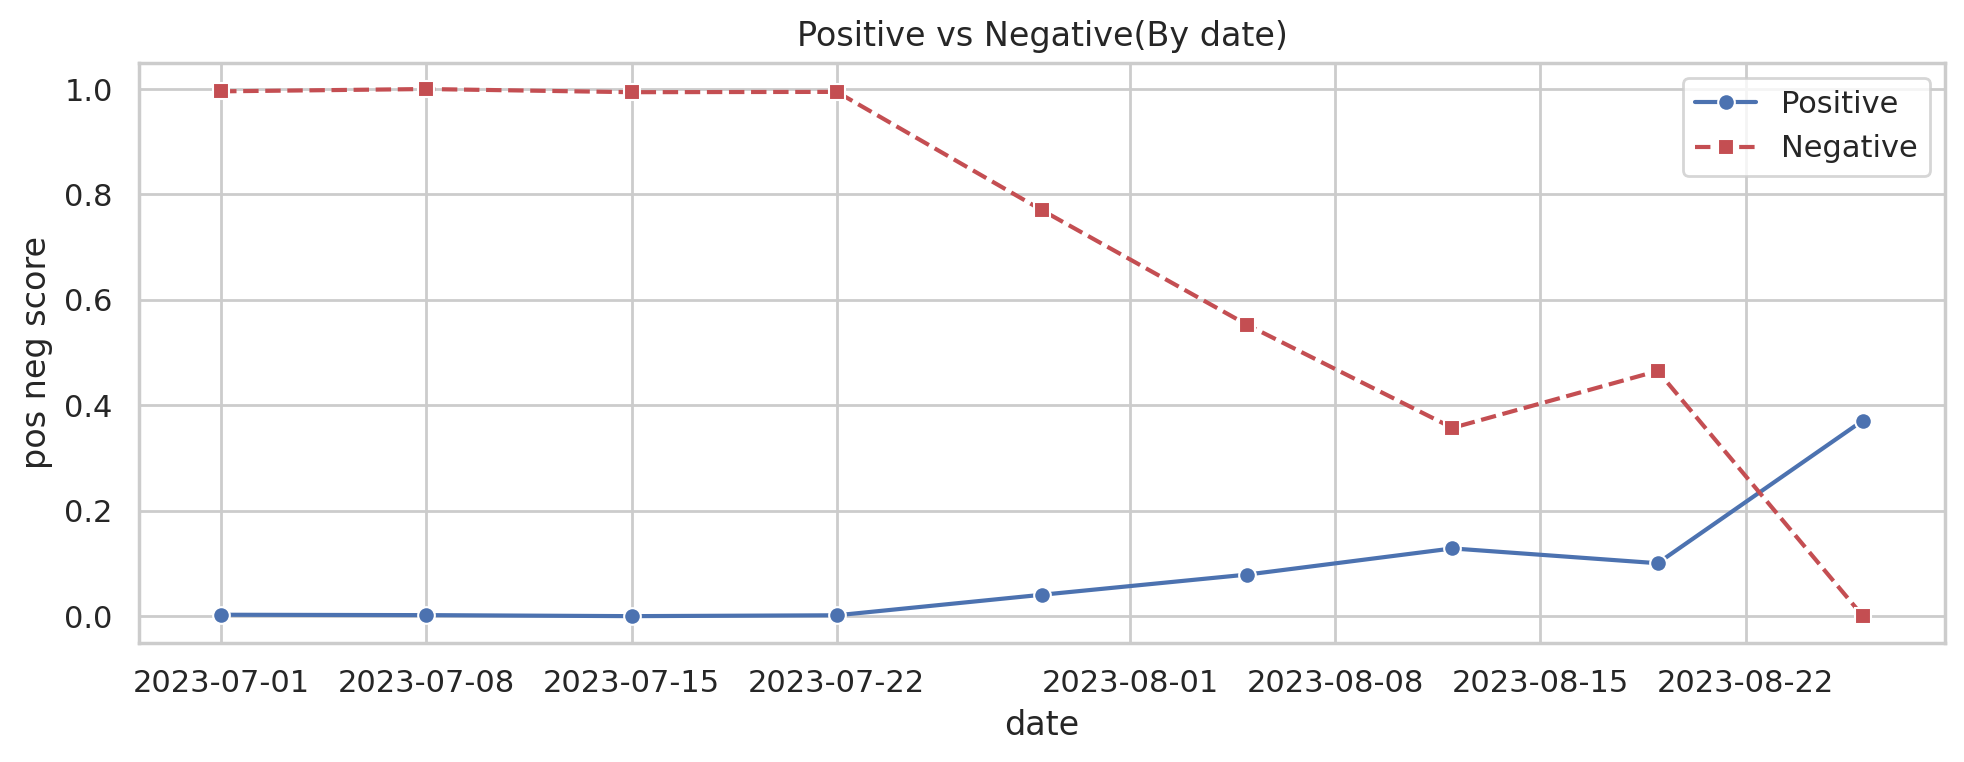

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 날짜를 Datetime 형식으로 변환
# merged_df['date'] = pd.to_datetime(merged_df['date'])

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 그래프 생성
plt.figure(figsize=(10, 4))  # 그래프 크기 설정

# score 1 그래프 그리기
sns.lineplot(data=merged_df, x='date', y='pos_7D_score', label='Positive', marker='o', linestyle='-', color='b')

# score 2 그래프 그리기
sns.lineplot(data=merged_df, x='date', y='neg_7D_score', label='Negative', marker='s', linestyle='--', color='r')

# 그래프 제목과 레이블 설정
plt.title('Positive vs Negative(By date)')
plt.xlabel('date')
plt.ylabel('pos neg score')

# 범례 추가
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


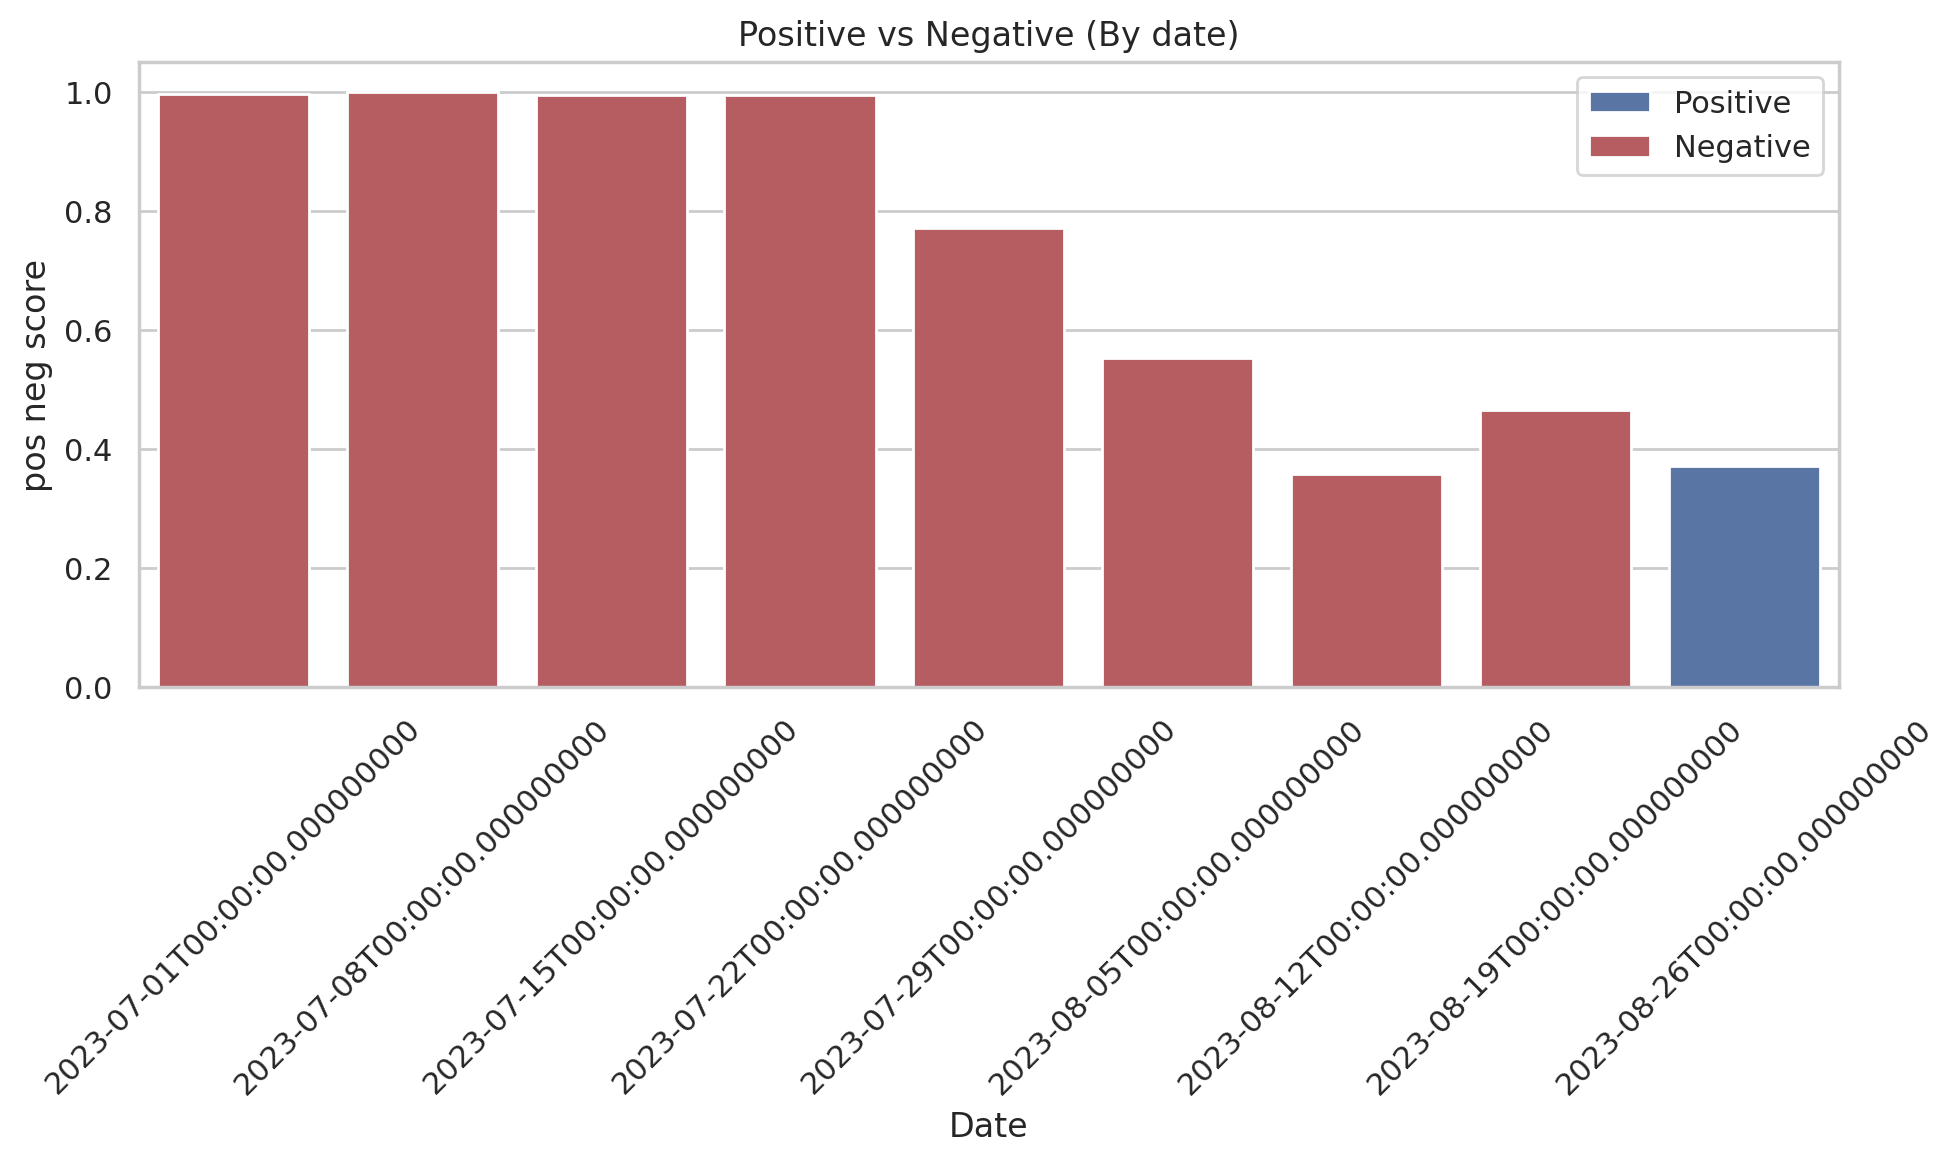

In [ ]:
# merged_df['date'] = pd.to_datetime(merged_df['date'])

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

# score 1 막대 그래프 그리기
sns.barplot(data=merged_df, x='date', y='pos_7D_score', color='b', label='Positive')

# score 2 막대 그래프 그리기
sns.barplot(data=merged_df, x='date', y='neg_7D_score', color='r', label='Negative')

# 그래프 제목과 레이블 설정
plt.title('Positive vs Negative (By date)')
plt.xlabel('Date')
plt.ylabel('pos neg score')

# 범례 추가
plt.legend()

# x 축 레이블 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()

# 3) (보류) 부정지수 토픽별 분포도

In [ ]:
#대충 이 부분을 어떻게 설명하면 좋을 지

# 4) 고객별 온도 확인 (리뷰 빈도 / 긍부정 / 토픽)

In [ ]:
train

,ID,date,review,reply,sentiment,score
0,ae**,2023-07-01,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",죄송합니다. 음식이 맛있지 않았던 점에 대해 정말로 죄송합니다. 저희는 항상 최상의...,0,-0.942769
1,ak**,2023-07-02,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","고객님께서는 음식의 맛과 촉감에 대해 불만을 표시해주셨는데, 이는 많이 실망스러워하...",0,-0.942769
2,am**,2023-07-03,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님께 불편을 드려 정말 죄송합니다. 담당자에게 알려서 조치를 취하도록 하겠습니다.,0,-0.942769
3,ap**,2023-07-04,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",죄송합니다. 다음에는 더 맛있는 음식을 제공하도록 노력하겠습니다.,0,-0.942769
4,ar**,2023-07-05,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","안녕하세요, 죄송합니다. 음식이 촉촉하지 않고 식어서 맛이 좋지 않았던 점에 대해 ...",0,-0.942769
...,...,...,...,...,...,...
995,br**,2023-09-13,정말 맛있게 잘먹었습니다 또 주문할게요!,안녕하세요 신자매 김치찜 김치찌개를 찾아주셔서 진심으로 감사합니다 정말 맛있게 드시...,1,0.828081
996,ca**,2023-09-14,두번째 시켜 먹는데요. 저번엔 회덮밥 이번엔 초밥입니다. 초밥도 맛있네요. 연어두께...,재주문 진심으로 반갑고 감사합니다 회덮밥 초밥 외에도 다양하고 푸짐한 구성의 도시락...,1,0.830169
997,ch**,2023-09-15,깔끔한 포장이랑 맛 다 최고였어요!,고객님 기운도 만땅으로 충전시켜드릴 수 있게 정성으로 준비하여 찾아뵐게요~ 매일매일...,1,0.831033
998,cj**,2023-09-16,너무너무 맛있게 잘먹었습니다 !,고객님의 입맛을 사로잡는 이배달이 되겠습니다 늘 만족하실수 있도록 고민 또 고민 중...,1,0.831412


In [ ]:
train['date'] = pd.to_datetime(train['date'])

In [ ]:
train

,ID,date,review,reply,sentiment,score
0,ae**,2023-07-01,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",죄송합니다. 음식이 맛있지 않았던 점에 대해 정말로 죄송합니다. 저희는 항상 최상의...,0,-0.942769
1,ak**,2023-07-02,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","고객님께서는 음식의 맛과 촉감에 대해 불만을 표시해주셨는데, 이는 많이 실망스러워하...",0,-0.942769
2,am**,2023-07-03,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님께 불편을 드려 정말 죄송합니다. 담당자에게 알려서 조치를 취하도록 하겠습니다.,0,-0.942769
3,ap**,2023-07-04,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",죄송합니다. 다음에는 더 맛있는 음식을 제공하도록 노력하겠습니다.,0,-0.942769
4,ar**,2023-07-05,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","안녕하세요, 죄송합니다. 음식이 촉촉하지 않고 식어서 맛이 좋지 않았던 점에 대해 ...",0,-0.942769
...,...,...,...,...,...,...
995,br**,2023-09-13,정말 맛있게 잘먹었습니다 또 주문할게요!,안녕하세요 신자매 김치찜 김치찌개를 찾아주셔서 진심으로 감사합니다 정말 맛있게 드시...,1,0.828081
996,ca**,2023-09-14,두번째 시켜 먹는데요. 저번엔 회덮밥 이번엔 초밥입니다. 초밥도 맛있네요. 연어두께...,재주문 진심으로 반갑고 감사합니다 회덮밥 초밥 외에도 다양하고 푸짐한 구성의 도시락...,1,0.830169
997,ch**,2023-09-15,깔끔한 포장이랑 맛 다 최고였어요!,고객님 기운도 만땅으로 충전시켜드릴 수 있게 정성으로 준비하여 찾아뵐게요~ 매일매일...,1,0.831033
998,cj**,2023-09-16,너무너무 맛있게 잘먹었습니다 !,고객님의 입맛을 사로잡는 이배달이 되겠습니다 늘 만족하실수 있도록 고민 또 고민 중...,1,0.831412


# ID 중복이 있어서 그런가...?

고객 ID: ch**


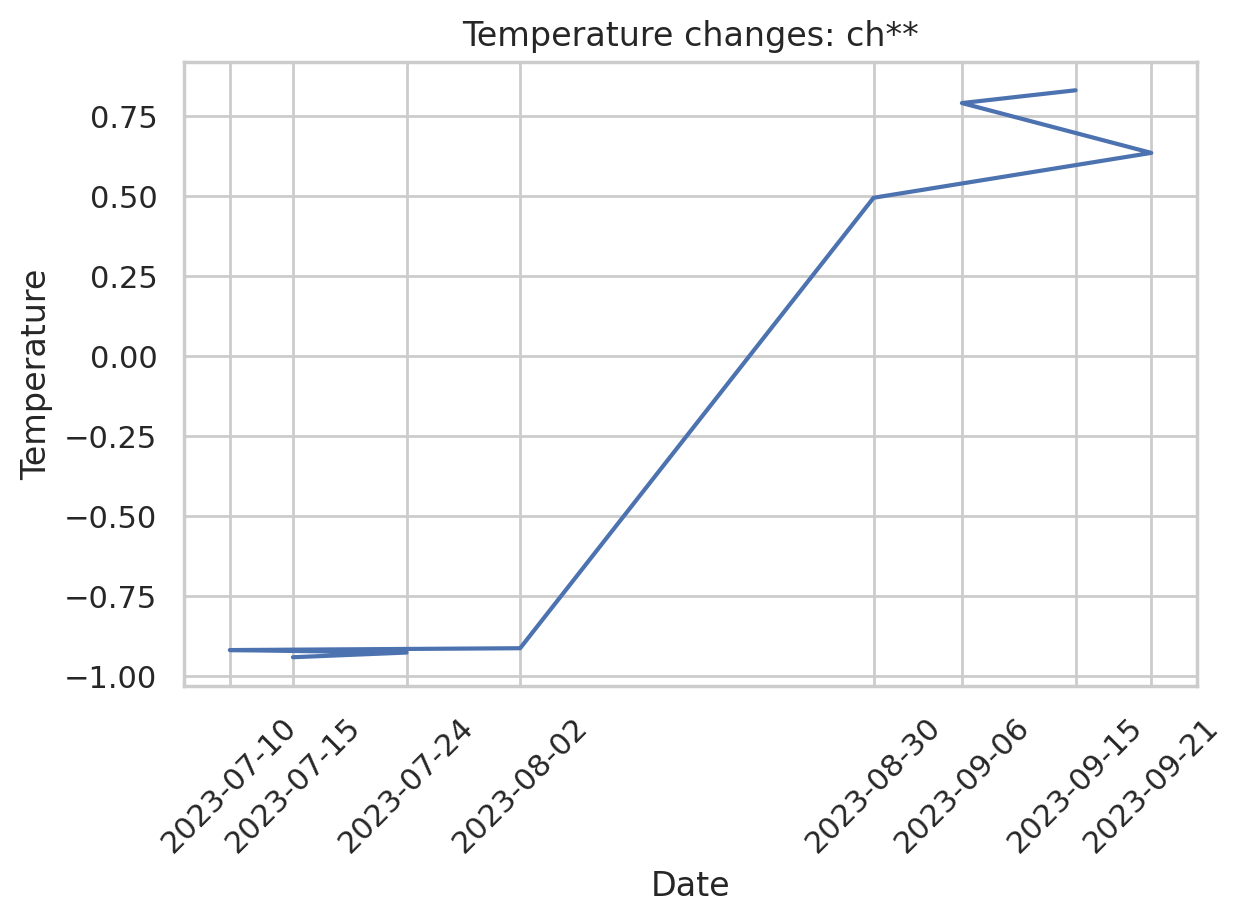

In [ ]:
input_id = input("고객 ID: ")

# id_df = temp_df[temp_df['ID'] == input_id]
id_df = train[train['ID'] == input_id]

if not id_df.empty:
    plt.plot(id_df['date'], id_df['score'])
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title(f'Temperature changes: {input_id}')
    plt.xticks(id_df['date'], rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"{input_id} : 없는 ID 입니다.")

고객 ID: ch**


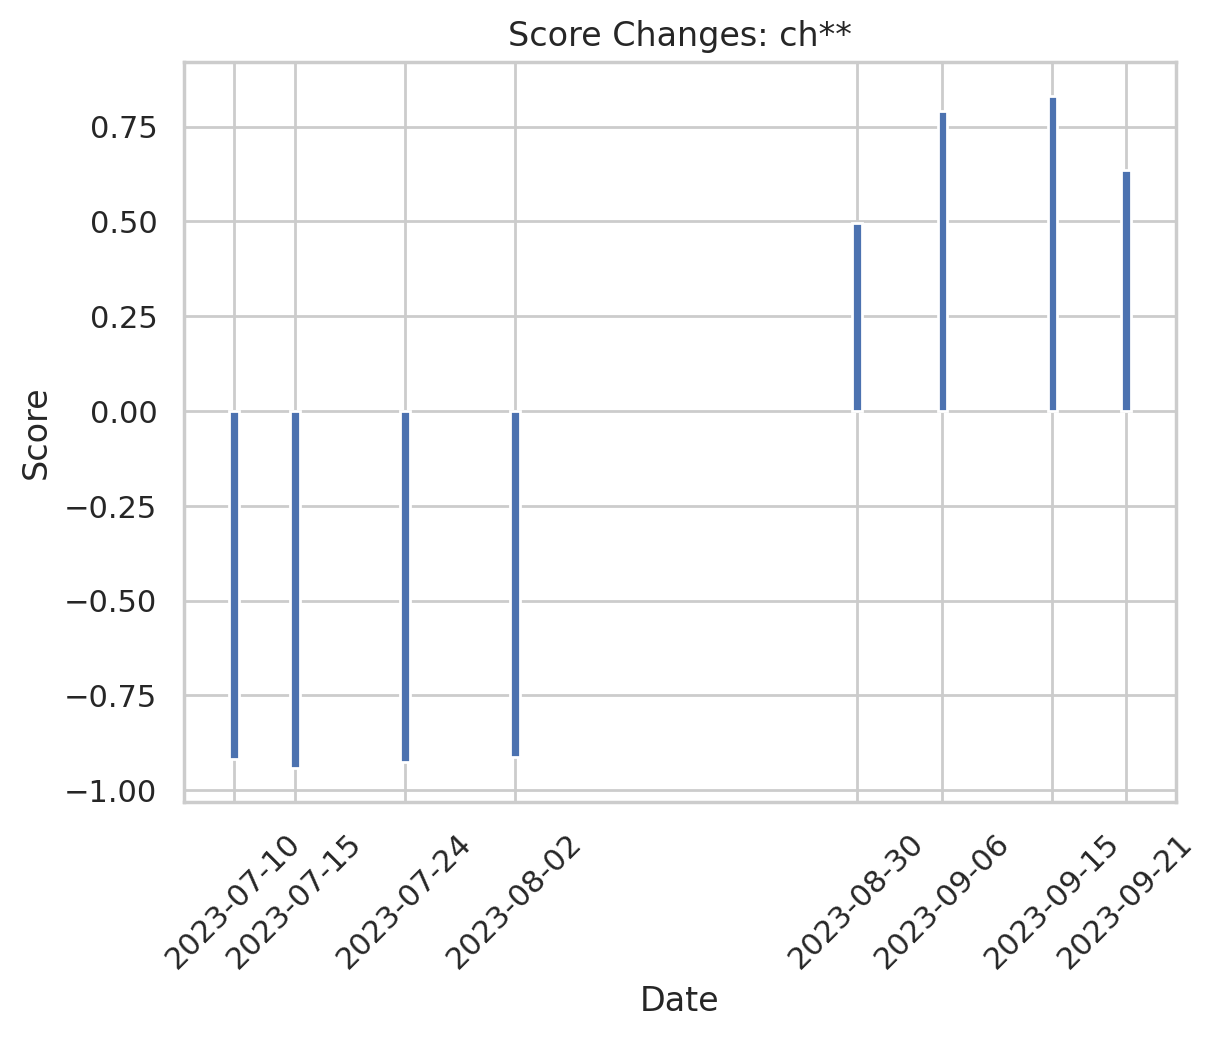

In [ ]:
input_id = input("고객 ID: ")

# id_df = temp_df[temp_df['ID'] == input_id]
id_df = train[train['ID'] == input_id]

if not id_df.empty:
    plt.bar(id_df['date'], id_df['score'])
    plt.xlabel('Date')
    plt.ylabel('Score')
    plt.title(f'Score Changes: {input_id}')
    plt.xticks(id_df['date'], rotation=45)
    plt.show()
else:
    print(f"{input_id}: 해당 ID가 없습니다.")